<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/Infrastructure_092525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
dpath = '/content/drive/MyDrive/Disertation/'

# -- import county shapes
fname = 'countyshp/tl_2010_us_county00/tl_2010_us_county00.shp'
counties = gpd.read_file(dpath+fname)
counties["GEOID"] = counties['STATEFP00'].str.zfill(2) + counties['COUNTYFP00'].str.zfill(3)
cols = ['GEOID', 'geometry']
counties = counties[cols]

# -- set crs
#crs = 'EPSG:4269'
crs = 'ESRI:102003'
counties = counties.to_crs(crs)

fname = '/content/drive/MyDrive/Disertation/stateshp/tl_2010_us_state10.shp'
states = gpd.read_file(fname)
states = states.to_crs(crs)
states = states[['GEOID10', 'geometry']].copy()

dpath = '/content/drive/MyDrive/Disertation/Infrastructure/'
# -- import highways
fname = 'BTS/Highways_DOT/Highways_DOT.shp'
highways = gpd.read_file(dpath+fname)
highways = highways.to_crs(crs)

# -- import Airports
fname = 'BTS/Airports_DOT/Airports_DOT.shp'
airports = gpd.read_file(dpath+fname)
airports = airports.to_crs(crs)

# -- import Ports
fname = 'BTS/Ports_DOT/Ports_DOT.shp'
ports = gpd.read_file(dpath+fname)
ports = ports.to_crs(crs)

# -- import rails
fname = 'BTS/Rail_DOT/Rail_DOT.shp'
rails = gpd.read_file(dpath+fname)
rails = rails.to_crs(crs)

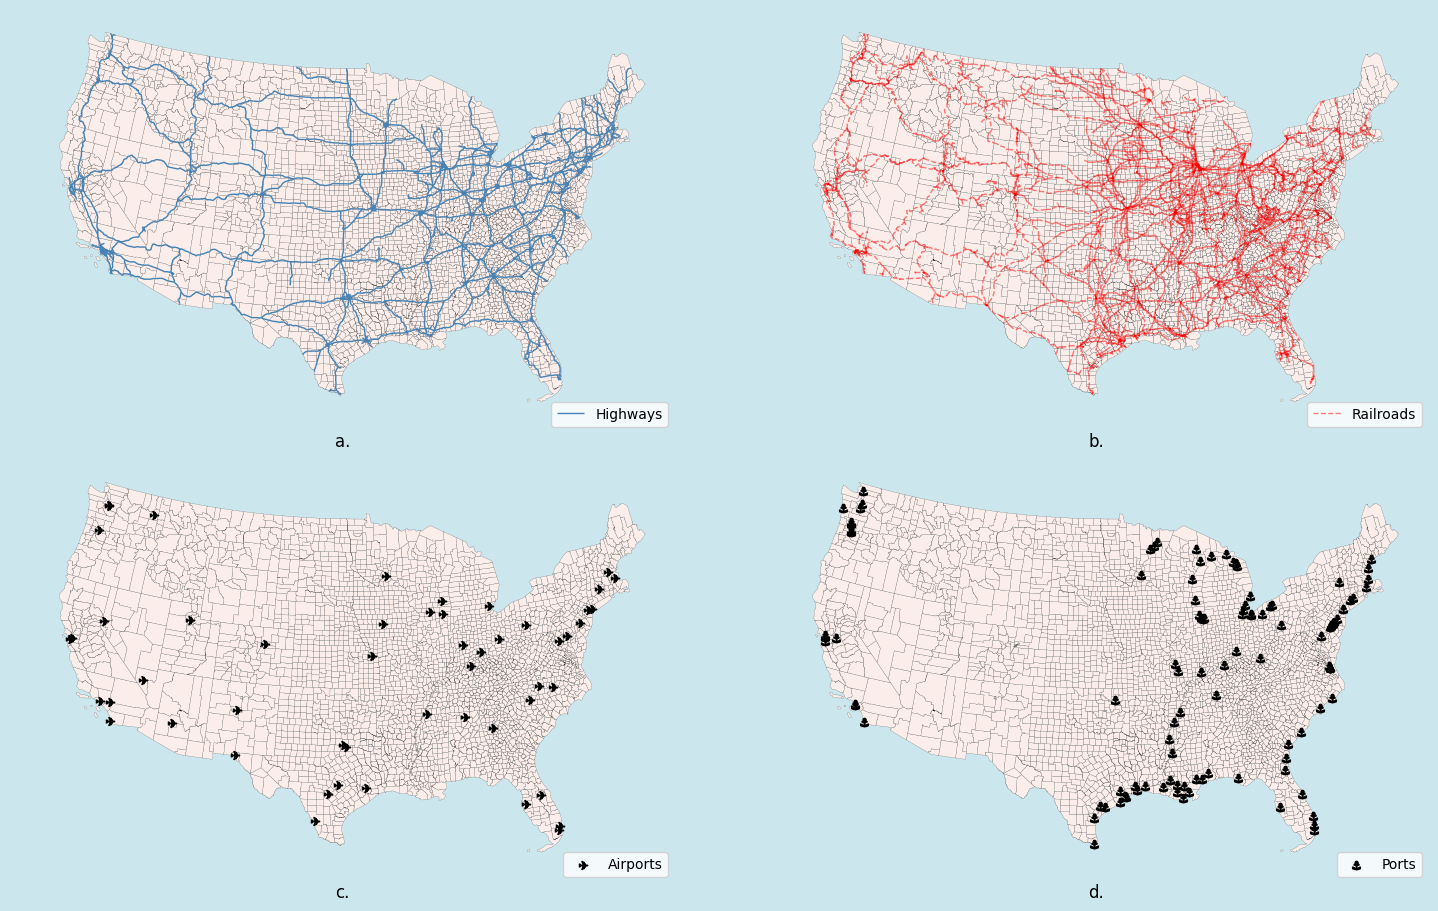

In [10]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(2, 2, figsize=(15, 9), constrained_layout=True, facecolor='#CCE6EE')
# For images
#x_lim = [-126, -65]
#y_lim = [24, 50]
# For calculations and images
x_lim = [-2750000, 2500000]
y_lim = [-1600000, 1750000,]
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[0,0])
highways.plot(linewidth=1, color = 'steelblue',   ax=ax[0,0], label='Highways')
ax[0,0].set_facecolor('#CCE6EE')
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[0,1])
rails.plot(linewidth=1, color = 'red', alpha=0.5, linestyle="--", ax=ax[0,1], label='Railroads')
ax[0,1].set_facecolor('#CCE6EE')
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[1,0])
plane = MarkerStyle("$\u2708$")  # Unicode airplane character
airports.plot(marker=plane, c='k', ax=ax[1,0], label="Airports")
ax[1,0].set_facecolor('#CCE6EE')
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[1,1])
anchor = MarkerStyle('$\u2693$') # Unicode anchor character
ports.plot(marker=anchor, c='k', ax=ax[1,1], label="Ports")
ax[1,1].set_facecolor('#CCE6EE')
# -- set legends
for row in range(2):
    for col in range(2):
        ax[row, col].legend(loc='lower right')
# -- set limits

for row in range(2):
    for col in range(2):
        ax[row, col].set_xlim(x_lim)
        ax[row, col].set_ylim(y_lim)

# -- remove axis from each subplot
for row in range(2):
    for col in range(2):
        ax[row, col].axis('off')
# -- add subtitles to each axis

ax[0, 0].set_title('a.', y=-0.05)
ax[0, 1].set_title('b.', y=-0.05)
ax[1, 0].set_title('c.', y=-0.05)
ax[1, 1].set_title('d.', y=-0.05)
fig.show()

Caption: a. Highways in the United States; b. Freight Rails in the Unites States; c. Freight Airports in the United States; d. Freight Ports in the United States. All data retrieved from the Bureau of Transportation Statistics' Interim National Multimodal Freight Network, and accessed in 2024.

In [168]:
# -- Removing non continental counties
nc_states = ['02', '15', '60', '66', '69', '72', '78']
for i in nc_states:
  counties = counties[~counties['GEOID'].str.startswith(i)]

highway_county = gpd.overlay(highways[["geometry"]], counties, how='intersection')

# -- Calculating the length of highway segment in each county
highway_county["highway_m"] = highway_county.length

# -- Adding a column for highway lenths by county in metre
highway_county = highway_county.groupby("GEOID").sum(numeric_only=True)

# -- Merging highway segments by county and the county dataset
counties = counties.merge(highway_county, on="GEOID", how="left")

# -- Filling NAN and sorting values
counties["highway_m"] = counties["highway_m"].fillna(0)
counties = counties.sort_values("GEOID")

# -- Deleting highway segments by county dataset
del highway_county

# -- Creating a copy of counties
counties_center = counties.copy()
# -- Creating an empty distance column
counties_center["dist_highway_m"] = 0.0
# -- Adding the centroid of each county to the geometry column
counties_center["geometry"] = counties_center.centroid

# -- Calculating distance from county centroid to the nearest highway
dist_to_highway = gpd.sjoin_nearest(counties_center, highways[["geometry"]], how="left",  distance_col="dist_highway_m")
# -- Dropping duplicates
dist_to_highway = dist_to_highway.drop_duplicates(subset='GEOID', keep='first')
dist_to_highway = dist_to_highway[["GEOID", "dist_highway_m"]]

# -- Adding dist to highway to the counties df
counties = counties.merge(dist_to_highway, on="GEOID", how="left")

# -- Deleting unnecessary data
del dist_to_highway, counties_center

In [169]:
# -- RAILROAD
# -- Making a copy of counties. I just need GEOID and geometry
counties_copy = counties[["GEOID", "geometry"]]
rail_county = gpd.overlay(rails[["geometry"]], counties_copy, how='intersection')

# -- Calculating the length of rail segment in each county
rail_county["rail_m"] = rail_county.length

# -- Adding a column for rail lenths by county in metre
rail_county = rail_county.groupby("GEOID").sum(numeric_only=True)

# -- Merging rail segments by county and the county dataset
counties = counties.merge(rail_county, on="GEOID", how="left")

# -- Filling NAN and sorting values
counties["rail_m"] = counties["rail_m"].fillna(0)
counties = counties.sort_values("GEOID")

# -- Deleting highway segments by county dataset
del rail_county

# -- Creating a copy of counties
counties_center = counties.copy()[["GEOID","geometry"]]
# -- Creating an empty distance column
counties_center["dist_rail_m"] = 0.0
# -- Adding the centroid of each county to the geometry column
counties_center["geometry"] = counties_center.centroid

# -- Calculating distance from county centroid to the nearest rail
dist_to_rail = gpd.sjoin_nearest(counties_center, rails[["geometry"]], how="left",  distance_col="dist_rail_m")

# -- Dropping duplicates
dist_to_rail = dist_to_rail.drop_duplicates(subset='GEOID', keep='first')
dist_to_rail = dist_to_rail[["GEOID", "dist_rail_m"]]

# -- Adding dist to highway to the counties df
counties = counties.merge(dist_to_rail, on="GEOID", how="left")

# -- Deleting unnecessary data
del dist_to_rail, counties_center

In [170]:
# PORTS
counties_copy = counties[["GEOID", "geometry"]]
ports_county = gpd.overlay(ports[["geometry"]], counties_copy, how='intersection')
ports_county = ports_county.groupby("GEOID").count().rename(columns={'geometry': 'ports'})
counties = counties.merge(ports_county, on="GEOID", how="left")
counties = counties.fillna(0)
del ports_county, counties_copy

# PORTS DISTANCE
counties_center = counties.copy()[["GEOID","geometry"]]
counties_center["dist_port_m"] = 0.0
counties_center["geometry"] = counties_center.centroid
dist_to_port = gpd.sjoin_nearest(counties_center, ports[["geometry"]], how="left",  distance_col="dist_port_m")
dist_to_port = dist_to_port.drop_duplicates(subset='GEOID', keep='first')
dist_to_port = dist_to_port[["GEOID", "dist_port_m"]]
counties = counties.merge(dist_to_port, on="GEOID", how="left")
del dist_to_port, counties_center

In [171]:
# AIPORTS
counties_copy = counties[["GEOID", "geometry"]]
airports_county = gpd.overlay(airports[["geometry"]], counties_copy, how='intersection')
airports_county = airports_county.groupby("GEOID").count().rename(columns={'geometry': 'airports'})
counties = counties.merge(airports_county, on="GEOID", how="left")
counties = counties.fillna(0)
del airports_county, counties_copy

# AIRPORTS DISTANCE
counties_center = counties.copy()[["GEOID","geometry"]]
counties_center["dist_airport_m"] = 0.0
counties_center["geometry"] = counties_center.centroid
dist_to_airport = gpd.sjoin_nearest(counties_center, airports[["geometry"]], how="left",  distance_col="dist_airport_m")
dist_to_airport = dist_to_airport.drop_duplicates(subset='GEOID', keep='first')
dist_to_airport = dist_to_airport[["GEOID", "dist_airport_m"]]
counties = counties.merge(dist_to_airport, on="GEOID", how="left")
del dist_to_airport, counties_center

In [177]:
counties

,GEOID,geometry,highway_m,dist_highway_m,rail_m,dist_rail_m,ports,dist_port_m,airports,dist_airport_m
0,01001,"POLYGON ((872352.117 -493195.205, 872464.226 -...",26515.585784,16816.548054,41199.856799,18864.747263,0.0,2.409292e+05,0.0,235123.800674
1,01003,"POLYGON ((796890.765 -686583.068, 796892.996 -...",95684.450614,932.510798,39049.758029,23525.435627,0.0,2.876627e+04,0.0,452733.358800
2,01005,"POLYGON ((974856.979 -567785.853, 974889.56 -5...",0.000000,72157.454966,0.000000,41278.737611,0.0,1.913971e+05,0.0,216686.000957
3,01007,"POLYGON ((830319.016 -444261.971, 830321.555 -...",0.000000,24401.742891,40459.310490,19104.752972,0.0,2.674723e+05,0.0,185902.923950
4,01009,"POLYGON ((849246.933 -369276.736, 849131.846 -...",11126.197881,25441.582044,21155.251912,16442.791643,0.0,2.451146e+05,0.0,75790.977647
...,...,...,...,...,...,...,...,...,...,...
3104,56037,"POLYGON ((-1023514.809 458542.628, -1023613.62...",227166.380275,3530.973991,355219.213970,3236.816424,0.0,1.132907e+06,0.0,275457.923311
3105,56039,"POLYGON ((-1203180.753 746139.929, -1203473.36...",0.000000,124231.639352,0.000000,123794.738214,0.0,9.697644e+05,0.0,369299.480384
3106,56041,"POLYGON ((-1214119.634 485278.384, -1214125.91...",91366.850647,1261.781187,119453.483120,7059.789214,0.0,9.886417e+05,0.0,131715.141200
3107,56043,"POLYGON ((-932192.388 745209.767, -932194.94 7...",0.000000,83028.967361,44932.872168,25654.378548,0.0,1.165696e+06,0.0,494956.671131


In [188]:
# -- Fast Act Urban and Rural Freight Corridors
fname = 'FAST Act/Critical Freight Corridors 112424 v2.shp'
CFC = gpd.read_file(dpath+fname)
CFC = CFC.to_crs(crs)

# -- Fast Act National Highway Freight Network
fname = 'FAST Act/National Highway Freight Network 112424 v2.shp'
NHFN = gpd.read_file(dpath+fname)
NHFN = NHFN.to_crs(crs)

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


In [186]:
NHFN

,NHFN,geometry
0,NonPHFS,"LINESTRING (662952.747 321095.371, 663000.63 3..."
1,NonPHFS,"LINESTRING (470027.583 454869.714, 470036.576 ..."
2,NonPHFS,"LINESTRING (643131.034 319475.103, 643164.237 ..."
3,NonPHFS,"LINESTRING (650920.722 322989.421, 650921.276 ..."
4,NonPHFS,"LINESTRING (529070.647 381152.758, 529084.955 ..."
...,...,...
9811,NonPHFS,"LINESTRING (891288.329 1044410.528, 891312.343..."
9812,NonPHFS,"LINESTRING (250794.894 1002771.789, 250771.237..."
9813,PHFS,"LINESTRING (1961656.349 782407.62, 1961659.552..."
9814,PHFS,"LINESTRING (1961607.671 783120.159, 1961612.98..."


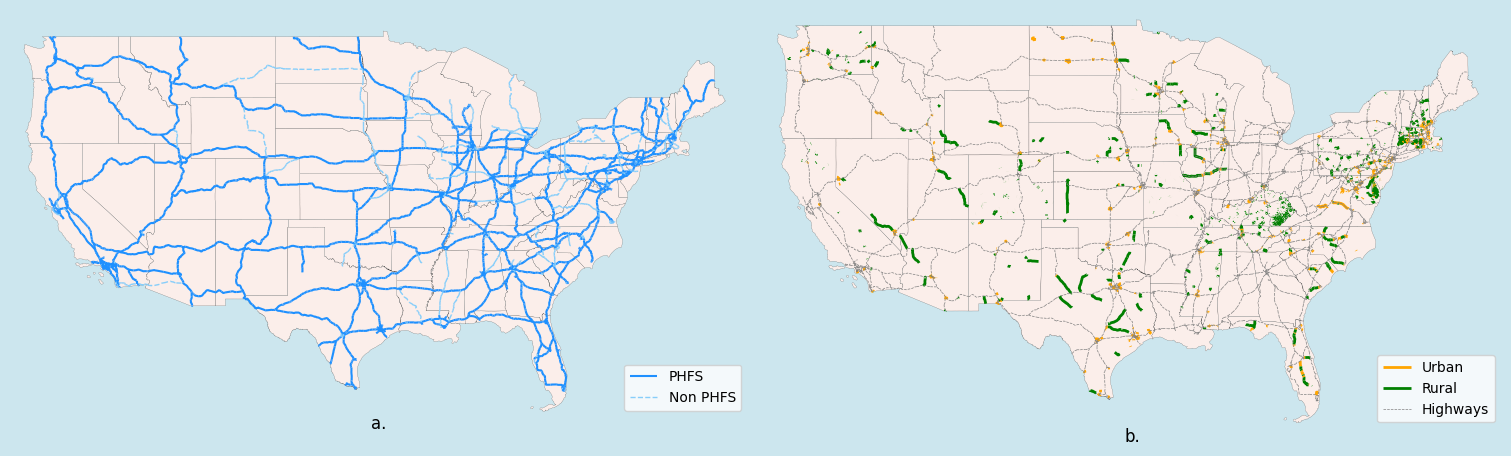

In [ ]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')
x_lim = [-126, -65]
y_lim = [24, 50]

states.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[0])
NHFN[NHFN['NHFN']==   'PHFS'].plot(linewidth=1.5, color = 'dodgerblue', ax=ax[0], label='PHFS')
NHFN[NHFN['NHFN']=='NonPHFS'].plot(linewidth=1, color = 'lightskyblue', linestyle='--', ax=ax[0], label='Non PHFS')


ax[0].set_facecolor('#CCE6EE')

states.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[1])
CFC[CFC['NHFN_PART']=='Urban'].plot(linewidth=2, color = 'orange', alpha=1, ax=ax[1], label='Urban')
CFC[CFC['NHFN_PART']=='Rural'].plot(linewidth=2, color = 'green', alpha=1, ax=ax[1], label='Rural')
highways.plot(linewidth=0.5, color = 'gray', linestyle='--', ax=ax[1], label='Highways')
ax[1].set_facecolor('#CCE6EE')

# -- set legends
for col in range(2):
  ax[col].legend(loc='lower right')
# -- set limits
for col in range(2):
  ax[col].set_xlim(x_lim)
  ax[col].set_ylim(y_lim)
# -- remove axis from each subplot
for col in range(2):
  ax[col].axis('off')
# -- add subtitles to each axis
ax[0].set_title('a.', y=-0.05)
ax[1].set_title('b.', y=-0.05)

fig.show()

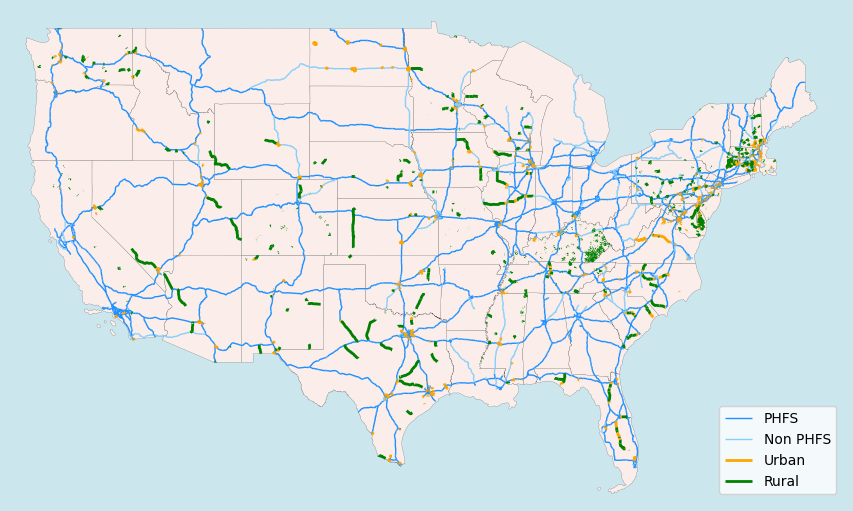

In [ ]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')
x_lim = [-126, -65]
y_lim = [24, 50]

states.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax)
NHFN[NHFN['NHFN']==   'PHFS'].plot(linewidth=1, color = 'dodgerblue', ax=ax, label='PHFS')
NHFN[NHFN['NHFN']=='NonPHFS'].plot(linewidth=1, color = 'lightskyblue', ax=ax, label='Non PHFS')
CFC[CFC['NHFN_PART']=='Urban'].plot(linewidth=2, color = 'orange', alpha=1, ax=ax, label='Urban')
CFC[CFC['NHFN_PART']=='Rural'].plot(linewidth=2, color = 'green', alpha=1, ax=ax, label='Rural')

ax.set_facecolor('#CCE6EE')

ax.legend(loc='lower right')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axis('off')

fig.show()

Question 16: Can a non-PHFS Interstate System route be designated as a CRFC or CUFC? (Added May 23, 2016)

Answer 16: Yes, the law does not prohibit the designation of a non-PHFS Interstate System route as a CRFC or CUFC. For a CRFC, the designated public road cannot be in an urbanized area and must meet one or more of the elements listed in 23 U.S.C. 167(e)(1). For a CUFC, the designated public road must be in an urbanized area and meet one or more of the elements listed in 23 U.S.C. 167(f)(3). Note that the designation of a non-PHFS Interstate System route as a CRFC or CUFC will count against the cap on mileage designation, which is established on a Statewide basis (23 U.S.C. 167(e)(2) and (f)(4)).

In [ ]:
# -- intermodal facilies
fname = 'NTAD_Intermodal_Freight_Facilities_Air_to_Truck/Intermodal_Freight_Facilities_Air-to-Truck.shp'
air_truck = gpd.read_file(dpath+fname)
air_truck = air_truck.to_crs(crs)
cols =['FACILITY_C', 'geometry']
air_truck = air_truck[cols]

fname = 'NTAD_Intermodal_Freight_Facilities_Rail_TOFC_COFC/Intermodal_Freight_Facilities_Rail_TOFC_COFC.shp'
rail_tofc = gpd.read_file(dpath+fname)
rail_tofc = rail_tofc.to_crs(crs)
cols = ['EQUIPMENT', 'geometry']
rail_tofc = rail_tofc[cols]

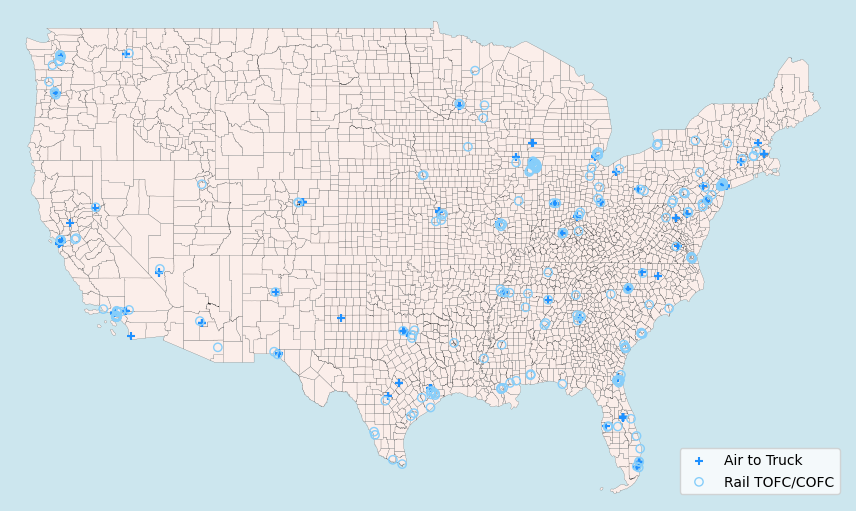

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')

counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax)
air_truck.plot(marker='+', color = 'dodgerblue', ax=ax, label='Air to Truck')
rail_tofc.plot(marker='o', facecolor='none', edgecolor='lightskyblue', ax=ax, label='Rail TOFC/COFC')

ax.set_facecolor('#CCE6EE')
ax.legend(loc='lower right')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axis('off')

plt.show()

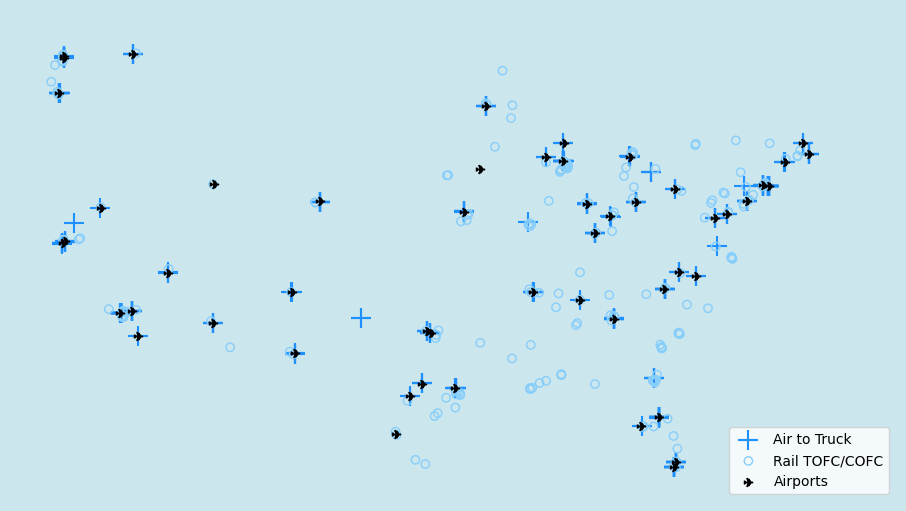

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')

#counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax)
air_truck.plot(marker='+',markersize=200, color = 'dodgerblue', ax=ax, label='Air to Truck')
rail_tofc.plot(marker='o', facecolor='none', edgecolor='lightskyblue', ax=ax, label='Rail TOFC/COFC')
airports.plot(marker=plane, c='k', ax=ax, label="Airports")

ax.set_facecolor('#CCE6EE')
ax.legend(loc='lower right')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axis('off')

plt.show()